In [28]:
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, 
GlobalAveragePooling1D, Dense)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

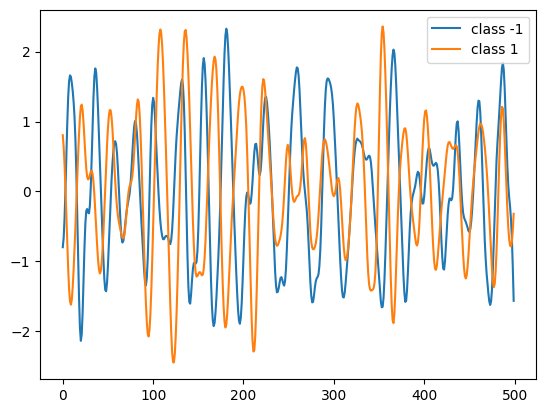

In [30]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [31]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [32]:
num_classes = len(np.unique(y_train))

In [33]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [34]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Model

In [40]:
def TimeseriesModel(input_shape, num_classes):
    inputLayer = Input(shape=input_shape)

    layer1 = Conv1D(filters=64, kernel_size=3, padding="same")(inputLayer)
    layer1 = BatchNormalization()(layer1)
    layer1 = ReLU()(layer1)

    layer2 = Conv1D(filters=64, kernel_size=3, padding="same")(layer1)
    layer2 = BatchNormalization()(layer2)
    layer2 = ReLU()(layer2)

    layer3 = Conv1D(filters=64, kernel_size=3, padding="same")(layer2)
    layer3 = BatchNormalization()(layer3)
    layer3 = ReLU()(layer3)

    pooling = GlobalAveragePooling1D()(layer3)

    outputLayer = Dense(units=num_classes, activation="softmax")(pooling) 

    return Model(inputs=inputLayer, outputs=outputLayer)
    

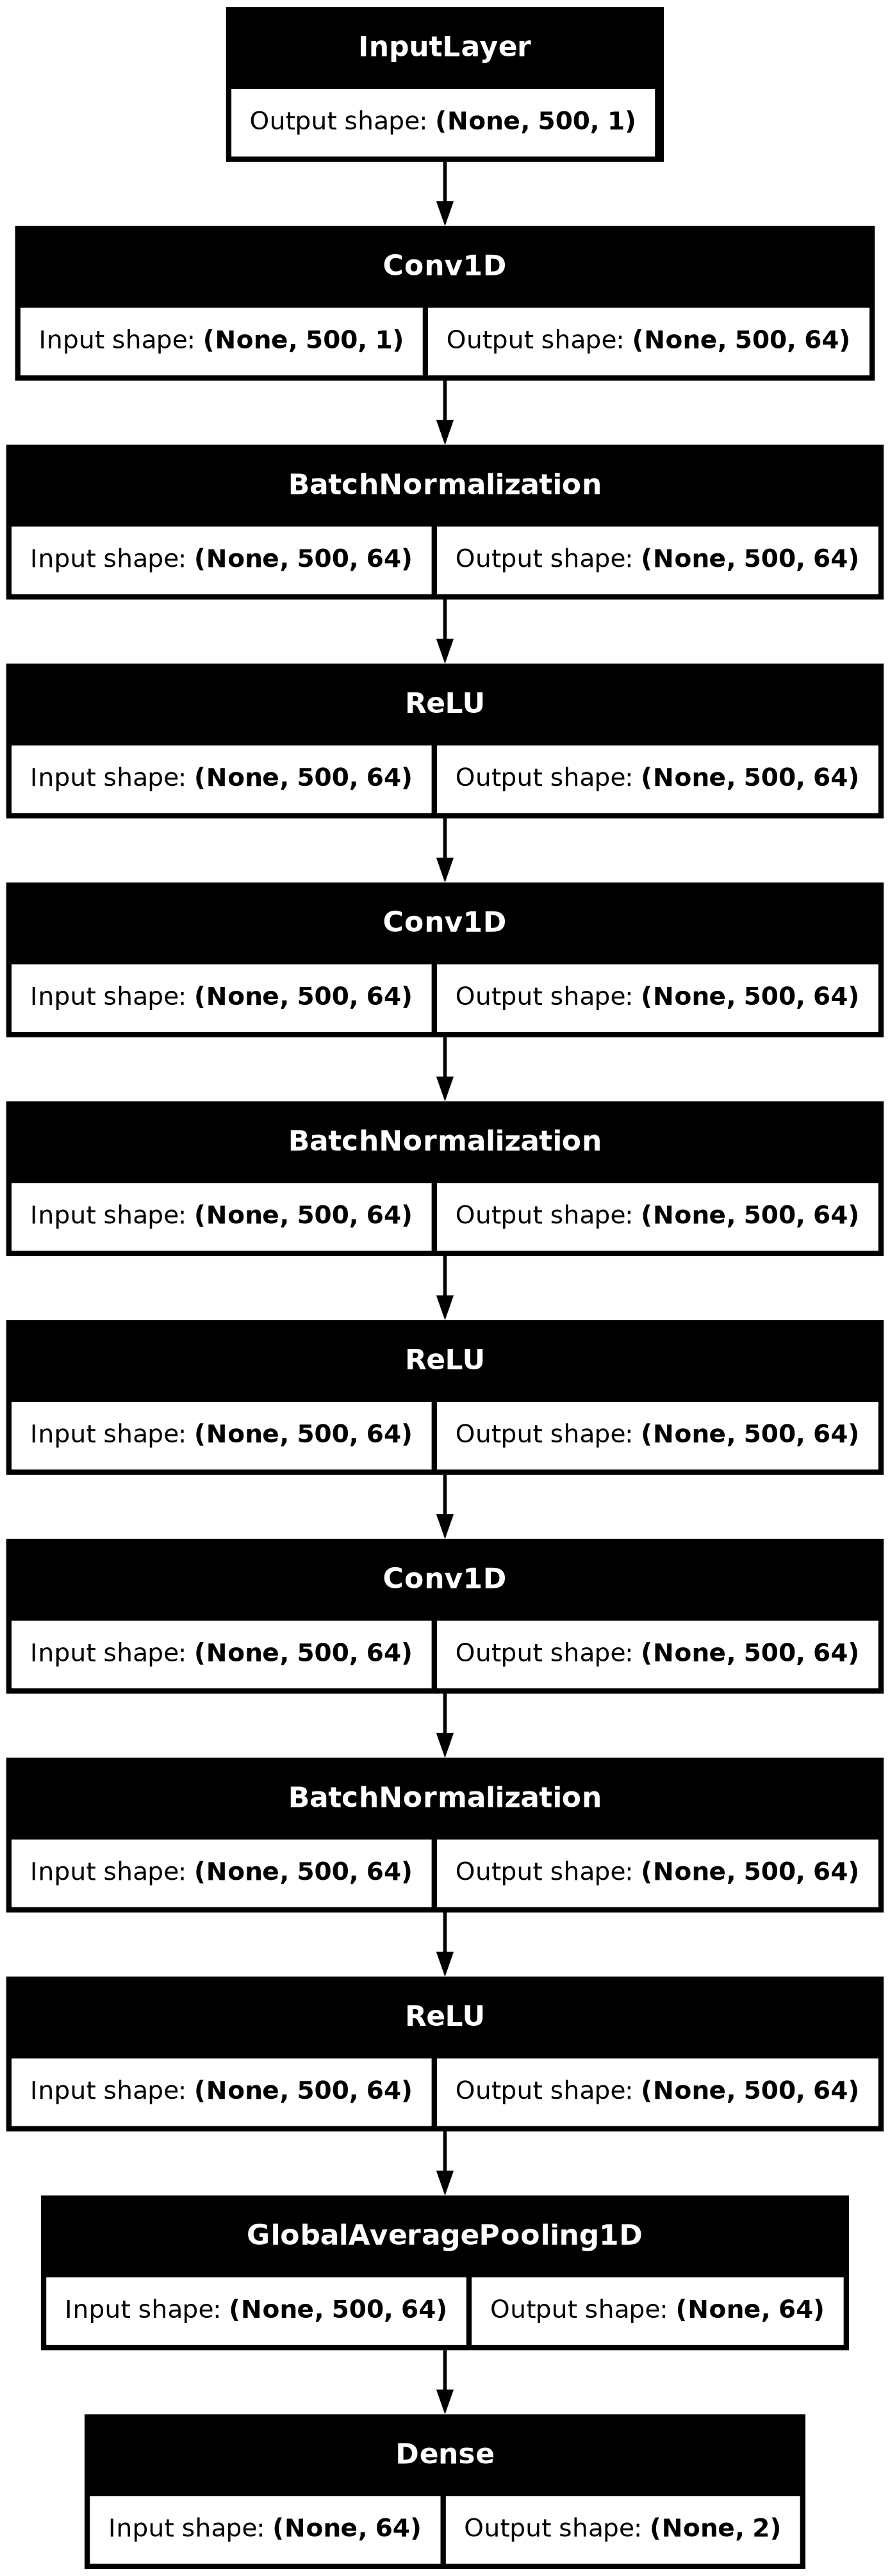

In [41]:
model = TimeseriesModel(input_shape=x_train.shape[1:], num_classes=num_classes)
plot_model(model=model, show_shapes=True)

In [42]:
callbacks = [
    ModelCheckpoint(filepath="best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001),
    EarlyStopping(monitor='val_loss', patience=3)
]

In [43]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"] )

history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, verbose=1, 
                   validation_split=0.2, callbacks=callbacks)


Epoch 1/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.6153 - sparse_categorical_accuracy: 0.6139 - val_loss: 0.7735 - val_sparse_categorical_accuracy: 0.4896 - learning_rate: 0.0010
Epoch 2/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.4885 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.4896 - learning_rate: 0.0010


In [44]:
model = load_model('best_model.keras')

test_loss, test_acc = model.evaluate(x=x_test, y=y_test)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7883 - sparse_categorical_accuracy: 0.4701
Test loss:  0.7773727178573608
Test accuracy:  0.4840908944606781


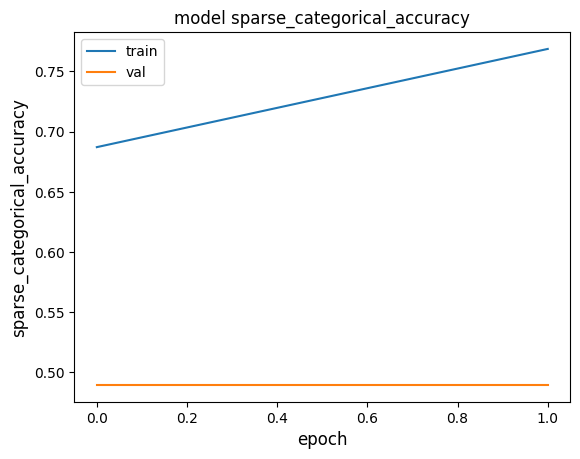

In [45]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()